<a href="https://colab.research.google.com/github/mattfarrow1/7331-machine-learning-1/blob/main/Labs/Lab1_Group4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab One: Visualization and Data Preprocessing

Matt Farrow, Amber Clark, Blake Freeman, Megan Ball

## 2015 Flight Delays and Cancellations
Data Source: [Kaggle](https://www.kaggle.com/usdot/flight-delays?select=flights.csv)

### Business Understanding

Describe the purpose of the data set you selected (i.e., why was this data collected in the first place?). Describe how you would define and measure the outcomes from the dataset. That is, why is this data important and how do you know if you have mined useful knowledge from the dataset? How would you measure the effectiveness of a good prediction algorithm? Be specific.

The data set that our group selected came the U.S. Department of Transportation's Bureau of Transportation Statistics and "tracks the on-time performance of domestic flights operated by large air carriers" during 2015. ([Kaggle](https://www.kaggle.com/usdot/flight-delays))

In [ ]:
# Load libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#force import the times as strings to keep leading zeroes. Later on will need to convert to time
dtype_t = {'SCHEDULED_DEPARTURE': str,
           'DEPARTURE_TIME': str,
           'WHEELS_OFF': str,
           'SCHEDULED_TIME': str,
           'WHEELS_ON': str,
           'SCHEDULED_ARRIVAL': str,
           'ARRIVAL_TIME': str
          }

# Read in the data using Pandas
# airlines = pd.read_csv('../Data/airlines.csv')
# airports = pd.read_csv('../Data/airports.csv')
# flights  = pd.read_csv('../Data/flights.csv', dtype = dtype_t)

# Read in the data directly from GitHub
airlines = pd.read_csv('https://raw.githubusercontent.com/mattfarrow1/7331-machine-learning-1/main/Data/airlines.csv')
airports = pd.read_csv('https://raw.githubusercontent.com/mattfarrow1/7331-machine-learning-1/main/Data/airports.csv')
flights  = pd.read_csv('https://media.githubusercontent.com/media/mattfarrow1/7331-machine-learning-1/main/Data/flights.csv', dtype = dtype_t)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
airlines.head()

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways


In [ ]:
airports.head()

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447


In [ ]:
flights.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.0,-11.0,21.0,15.0,205.0,194.0,169.0,1448,404.0,4.0,430,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,2.0,-8.0,12.0,14.0,280.0,279.0,263.0,2330,737.0,4.0,750,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,18.0,-2.0,16.0,34.0,286.0,293.0,266.0,2296,800.0,11.0,806,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,15.0,-5.0,15.0,30.0,285.0,281.0,258.0,2342,748.0,8.0,805,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,24.0,-1.0,11.0,35.0,235.0,215.0,199.0,1448,254.0,5.0,320,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Rename columns in preparation for merge
airlines.rename(columns={'IATA_CODE': 'AIRLINE_CODE'}, inplace=True)
flights.rename(columns={'AIRLINE': 'AIRLINE_CODE'}, inplace=True)

In [ ]:
# Merge data together
df = pd.merge(flights, airlines, on='AIRLINE_CODE', how = 'left')

In [ ]:
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE_CODE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,AIRLINE
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.0,-11.0,21.0,15.0,205.0,194.0,169.0,1448,404.0,4.0,430,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,Alaska Airlines Inc.
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,2.0,-8.0,12.0,14.0,280.0,279.0,263.0,2330,737.0,4.0,750,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,American Airlines Inc.
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,18.0,-2.0,16.0,34.0,286.0,293.0,266.0,2296,800.0,11.0,806,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,US Airways Inc.
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,15.0,-5.0,15.0,30.0,285.0,281.0,258.0,2342,748.0,8.0,805,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,American Airlines Inc.
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,24.0,-1.0,11.0,35.0,235.0,215.0,199.0,1448,254.0,5.0,320,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,Alaska Airlines Inc.


### Data Meaning Type

Describe the meaning and type of data (scale, values, etc.) for each attribute in the data file.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5819079 entries, 0 to 5819078
Data columns (total 32 columns):
 #   Column               Dtype  
---  ------               -----  
 0   YEAR                 int64  
 1   MONTH                int64  
 2   DAY                  int64  
 3   DAY_OF_WEEK          int64  
 4   AIRLINE_CODE         object 
 5   FLIGHT_NUMBER        int64  
 6   TAIL_NUMBER          object 
 7   ORIGIN_AIRPORT       object 
 8   DESTINATION_AIRPORT  object 
 9   SCHEDULED_DEPARTURE  int64  
 10  DEPARTURE_TIME       float64
 11  DEPARTURE_DELAY      float64
 12  TAXI_OUT             float64
 13  WHEELS_OFF           float64
 14  SCHEDULED_TIME       float64
 15  ELAPSED_TIME         float64
 16  AIR_TIME             float64
 17  DISTANCE             int64  
 18  WHEELS_ON            float64
 19  TAXI_IN              float64
 20  SCHEDULED_ARRIVAL    int64  
 21  ARRIVAL_TIME         float64
 22  ARRIVAL_DELAY        float64
 23  DIVERTED             int64  
 24

In [ ]:
# Convert string columns to datetime
# Source: https://stackoverflow.com/questions/41514173/change-multiple-columns-in-pandas-dataframe-to-datetime
df.iloc[:, [9, 10, 13, 18, 20, 21]] = df.iloc[:, [9, 10, 13, 18, 20, 21]].apply(pd.to_datetime, format='%H%M', errors='coerce')

In [ ]:
# Convert from string to time here
df[["SCHEDULED_DEPARTURE", 
   "DEPARTURE_TIME", 
   "WHEELS_OFF", 
   "SCHEDULED_TIME", 
   "WHEELS_ON", 
   "SCHEDULED_ARRIVAL", 
   "ARRIVAL_TIME"]].head()

,SCHEDULED_DEPARTURE,DEPARTURE_TIME,WHEELS_OFF,SCHEDULED_TIME,WHEELS_ON,SCHEDULED_ARRIVAL,ARRIVAL_TIME
0,NaT,1900-01-01 23:54:00,1900-01-01 01:05:00,205.0,1900-01-01 04:04:00,1900-01-01 04:30:00,1900-01-01 04:08:00
1,1900-01-01 01:00:00,NaT,1900-01-01 01:04:00,280.0,1900-01-01 07:37:00,1900-01-01 07:50:00,1900-01-01 07:41:00
2,1900-01-01 02:00:00,1900-01-01 01:08:00,1900-01-01 03:04:00,286.0,1900-01-01 08:00:00,1900-01-01 08:06:00,1900-01-01 08:11:00
3,1900-01-01 02:00:00,1900-01-01 01:05:00,1900-01-01 03:00:00,285.0,1900-01-01 07:48:00,1900-01-01 08:05:00,1900-01-01 07:56:00
4,1900-01-01 02:05:00,1900-01-01 02:04:00,1900-01-01 03:05:00,235.0,1900-01-01 02:54:00,1900-01-01 03:20:00,1900-01-01 02:59:00


In [ ]:
# Convert YEAR, MONTH, DAY to date
# Source: https://stackoverflow.com/questions/54487059/pandas-how-to-create-a-single-date-column-from-columns-containing-year-month
df['FLIGHT_DATE'] = pd.to_datetime([f'{y}-{m}-{d}' for y, m, d in zip(df.YEAR, df.MONTH, df.DAY)])

### Data Quality

Verify data quality: Explain any missing values, duplicate data, and outliers. Are those mistakes? How do you deal with these problems? Give justifications for your methods.

In [ ]:
# How many missing values are there in the data?
df.isnull().sum()

YEAR                         0
MONTH                        0
DAY                          0
DAY_OF_WEEK                  0
AIRLINE_CODE                 0
FLIGHT_NUMBER                0
TAIL_NUMBER              14721
ORIGIN_AIRPORT               0
DESTINATION_AIRPORT          0
SCHEDULED_DEPARTURE        949
DEPARTURE_TIME           91367
DEPARTURE_DELAY          86153
TAXI_OUT                 89047
WHEELS_OFF               97662
SCHEDULED_TIME               6
ELAPSED_TIME            105071
AIR_TIME                105071
DISTANCE                     0
WHEELS_ON               114534
TAXI_IN                  92513
SCHEDULED_ARRIVAL        14596
ARRIVAL_TIME            118200
ARRIVAL_DELAY           105071
DIVERTED                     0
CANCELLED                    0
CANCELLATION_REASON    5729195
AIR_SYSTEM_DELAY       4755640
SECURITY_DELAY         4755640
AIRLINE_DELAY          4755640
LATE_AIRCRAFT_DELAY    4755640
WEATHER_DELAY          4755640
AIRLINE                      0
FLIGHT_D

There are millions of missing values in the cancellation reason and the specific delay time columns. This is expected, as not every flight is cancelled or delayed, and you would hope that percentage would be small of the overall flights. It may make sense to change this to 0 instead of a missing value.

The missing rows for departure time and departure delay are trickier. We would not want to skew our results here so based on the fact that there are only about 2% of the values missing here, it would make sense to just remove these values and then re-assess how many missing values are left in the other features. Then there are also some values we could calculate as they are dependent on other variables.

In [ ]:
# Replace missing values in AIRLINE_DELAY, AIR_SYSTEM_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY, and WEATHER_DELAY with '0'
df[['AIRLINE_DELAY', 'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY']] = df[['AIRLINE_DELAY', 'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY']].fillna(value = 0)

In [ ]:
# How many missing values are there in the data now?
df.isnull().sum()

YEAR                         0
MONTH                        0
DAY                          0
DAY_OF_WEEK                  0
AIRLINE_CODE                 0
FLIGHT_NUMBER                0
TAIL_NUMBER              14721
ORIGIN_AIRPORT               0
DESTINATION_AIRPORT          0
SCHEDULED_DEPARTURE          0
DEPARTURE_TIME           86666
DEPARTURE_DELAY          86153
TAXI_OUT                 89047
WHEELS_OFF               89774
SCHEDULED_TIME               6
ELAPSED_TIME            105071
AIR_TIME                105071
DISTANCE                     0
WHEELS_ON                94518
TAXI_IN                  92513
SCHEDULED_ARRIVAL            2
ARRIVAL_TIME             94969
ARRIVAL_DELAY           105071
DIVERTED                     0
CANCELLED                    0
CANCELLATION_REASON    5729195
AIR_SYSTEM_DELAY             0
SECURITY_DELAY               0
AIRLINE_DELAY                0
LATE_AIRCRAFT_DELAY          0
WEATHER_DELAY                0
AIRLINE                      0
FLIGHT_D

In [ ]:
# One hot encode CANCELLATION_REASON where NA = 0
# Source: datagy.io/pandas-get-dummies/

# Convert missing values to '0'
df['CANCELLATION_REASON'] = df['CANCELLATION_REASON'].fillna(0)

# One hot encode
one_hot_columns = ['CANCELLATION_REASON']

for column in one_hot_columns:
  tempdf = pd.get_dummies(df[column], prefix=column)

  df = pd.merge(
      left = df,
      right = tempdf,
      left_index = True,
      right_index = True,
  )

  df = df.drop(columns=column)

df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE_CODE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,AIRLINE,FLIGHT_DATE,CANCELLATION_REASON_0,CANCELLATION_REASON_A,CANCELLATION_REASON_B,CANCELLATION_REASON_C,CANCELLATION_REASON_D
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,1900-01-01 00:05:00,1900-01-01 23:54:00,-11.0,21.0,1900-01-01 00:15:00,205,194.0,169.0,1448,1900-01-01 04:04:00,4.0,1900-01-01 04:30:00,1900-01-01 04:08:00,-22.0,0,0,0.0,0.0,0.0,0.0,0.0,Alaska Airlines Inc.,2015-01-01,1,0,0,0,0
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,1900-01-01 00:10:00,1900-01-01 00:02:00,-8.0,12.0,1900-01-01 00:14:00,280,279.0,263.0,2330,1900-01-01 07:37:00,4.0,1900-01-01 07:50:00,1900-01-01 07:41:00,-9.0,0,0,0.0,0.0,0.0,0.0,0.0,American Airlines Inc.,2015-01-01,1,0,0,0,0
2,2015,1,1,4,US,840,N171US,SFO,CLT,1900-01-01 00:20:00,1900-01-01 00:18:00,-2.0,16.0,1900-01-01 00:34:00,286,293.0,266.0,2296,1900-01-01 08:00:00,11.0,1900-01-01 08:06:00,1900-01-01 08:11:00,5.0,0,0,0.0,0.0,0.0,0.0,0.0,US Airways Inc.,2015-01-01,1,0,0,0,0
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,1900-01-01 00:20:00,1900-01-01 00:15:00,-5.0,15.0,1900-01-01 00:30:00,285,281.0,258.0,2342,1900-01-01 07:48:00,8.0,1900-01-01 08:05:00,1900-01-01 07:56:00,-9.0,0,0,0.0,0.0,0.0,0.0,0.0,American Airlines Inc.,2015-01-01,1,0,0,0,0
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,1900-01-01 00:25:00,1900-01-01 00:24:00,-1.0,11.0,1900-01-01 00:35:00,235,215.0,199.0,1448,1900-01-01 02:54:00,5.0,1900-01-01 03:20:00,1900-01-01 02:59:00,-21.0,0,0,0.0,0.0,0.0,0.0,0.0,Alaska Airlines Inc.,2015-01-01,1,0,0,0,0


In [1]:
# How many missing values are there in the data now?
df.isnull().sum()

NameError: ignored

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


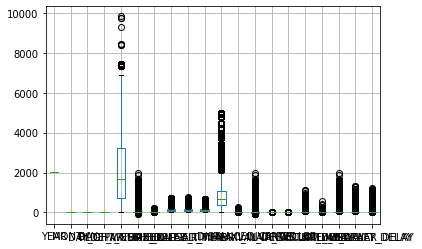

In [ ]:
# Check for outliers on continuous variables
# Source: https://stackoverflow.com/questions/25039626/how-do-i-find-numeric-columns-in-pandas
num_col = df.select_dtypes(include = np.number).columns.tolist() 
df.boxplot(column = num_col)

Note... need to do some more work here, group at different scales or split out individually

### Simple Statistics

Visualize appropriate statistics (e.g., range, mode, mean, median, variance, counts) for a subset of attributes. Describe anything meaningful you found from this or if you found something potentially interesting. Note: You can also use data from other sources for comparison. Explain why the statistics run are meaningful. 

In [ ]:
df.describe()

,YEAR,MONTH,DAY,DAY_OF_WEEK,FLIGHT_NUMBER,DEPARTURE_DELAY,TAXI_OUT,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,TAXI_IN,ARRIVAL_DELAY,DIVERTED,CANCELLED,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
count,5819079.0,5.819079e+06,5.819079e+06,5.819079e+06,5.819079e+06,5.732926e+06,5.730032e+06,5.819073e+06,5.714008e+06,5.714008e+06,5.819079e+06,5.726566e+06,5.714008e+06,5.819079e+06,5.819079e+06,1.063439e+06,1.063439e+06,1.063439e+06,1.063439e+06,1.063439e+06
mean,2015.0,6.524085e+00,1.570459e+01,3.926941e+00,2.173093e+03,9.370158e+00,1.607166e+01,1.416859e+02,1.370062e+02,1.135116e+02,8.223565e+02,7.434971e+00,4.407057e+00,2.609863e-03,1.544643e-02,1.348057e+01,7.615387e-02,1.896955e+01,2.347284e+01,2.915290e+00
std,0.0,3.405137e+00,8.783425e+00,1.988845e+00,1.757064e+03,3.708094e+01,8.895574e+00,7.521058e+01,7.421107e+01,7.223082e+01,6.077843e+02,5.638548e+00,3.927130e+01,5.102012e-02,1.233201e-01,2.800368e+01,2.143460e+00,4.816164e+01,4.319702e+01,2.043334e+01
min,2015.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-8.200000e+01,1.000000e+00,1.800000e+01,1.400000e+01,7.000000e+00,2.100000e+01,1.000000e+00,-8.700000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2015.0,4.000000e+00,8.000000e+00,2.000000e+00,7.300000e+02,-5.000000e+00,1.100000e+01,8.500000e+01,8.200000e+01,6.000000e+01,3.730000e+02,4.000000e+00,-1.300000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2015.0,7.000000e+00,1.600000e+01,4.000000e+00,1.690000e+03,-2.000000e+00,1.400000e+01,1.230000e+02,1.180000e+02,9.400000e+01,6.470000e+02,6.000000e+00,-5.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,0.000000e+00,2.000000e+00,3.000000e+00,0.000000e+00
75%,2015.0,9.000000e+00,2.300000e+01,6.000000e+00,3.230000e+03,7.000000e+00,1.900000e+01,1.730000e+02,1.680000e+02,1.440000e+02,1.062000e+03,9.000000e+00,8.000000e+00,0.000000e+00,0.000000e+00,1.800000e+01,0.000000e+00,1.900000e+01,2.900000e+01,0.000000e+00
max,2015.0,1.200000e+01,3.100000e+01,7.000000e+00,9.855000e+03,1.988000e+03,2.250000e+02,7.180000e+02,7.660000e+02,6.900000e+02,4.983000e+03,2.480000e+02,1.971000e+03,1.000000e+00,1.000000e+00,1.134000e+03,5.730000e+02,1.971000e+03,1.331000e+03,1.211000e+03


### Visualize Attributes

Visualize the most interesting attributes (at least 5 attributes, your opinion on what is interesting). Important: Interpret the implications for each visualization. Explain for each attribute why the chosen visualization is appropriate.

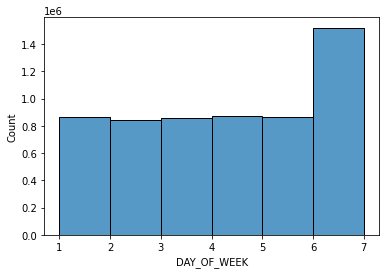

In [ ]:
# Flights by day of the week
sns.histplot(df, x = 'DAY_OF_WEEK', binwidth = 1)

### Explore Joint Attributes

Visualize relationships between attributes: Look at the attributes via scatter plots, correlation, cross-tabulation, group-wise averages, etc. as appropriate. Explain any interesting relationships.

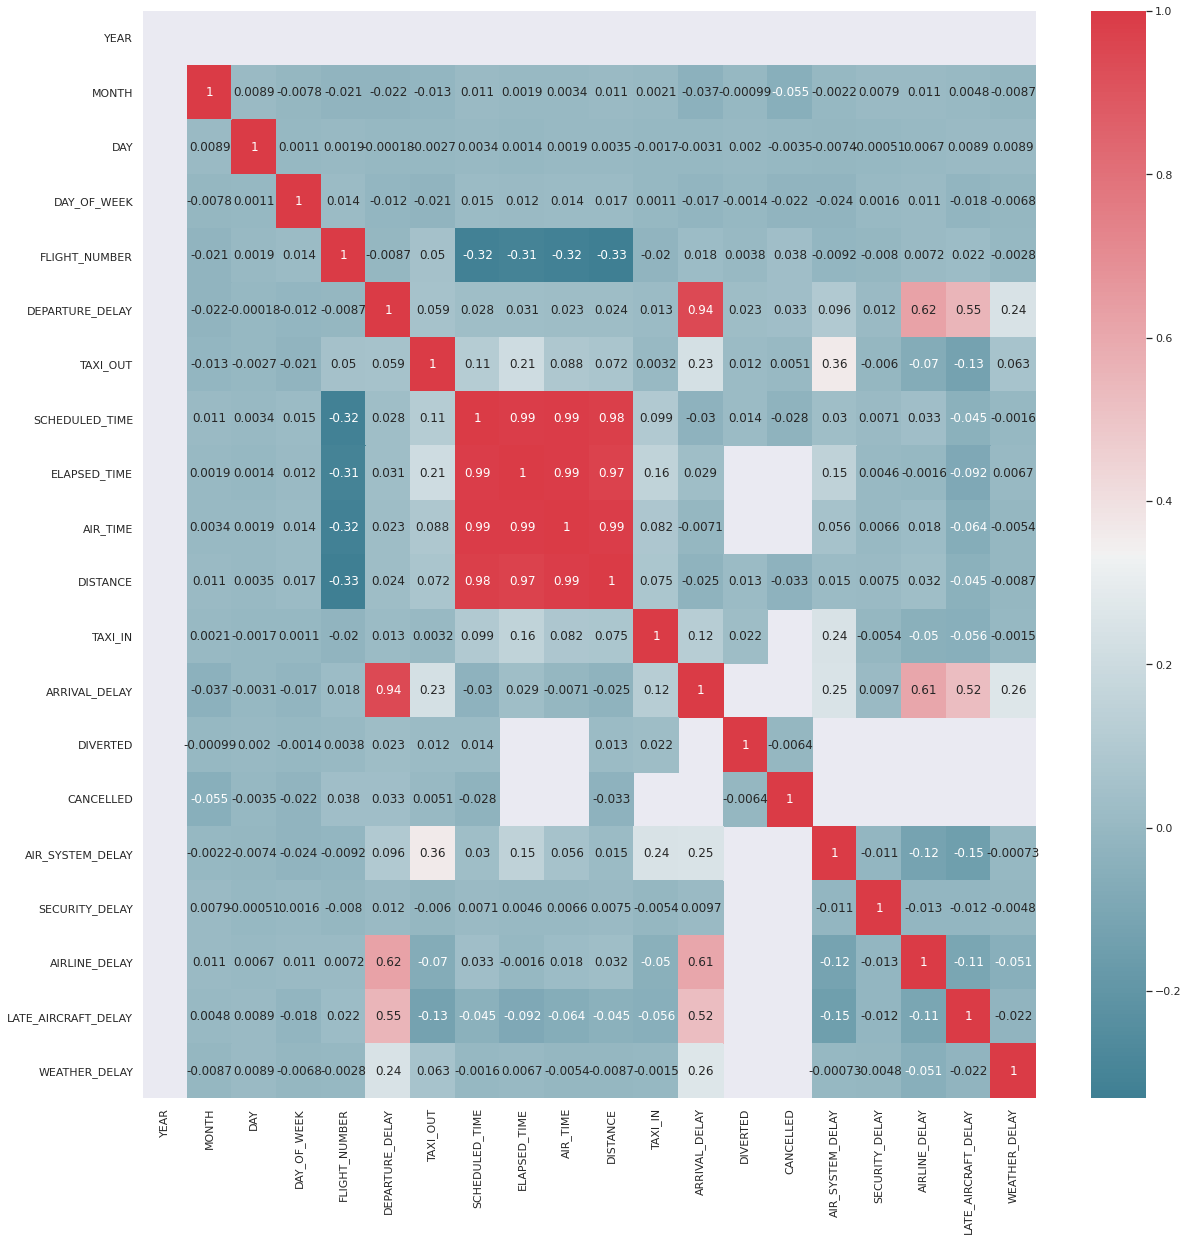

In [ ]:
# Examine correlation visually using Seaborn. (Code adapted from 02. Data Visualization.ipynb)
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.set(style = "darkgrid") # one of the many styles to plot using

f, ax = plt.subplots(figsize = (20, 20))

sns.heatmap(df.corr(), cmap=cmap, annot = True)

### Explore Attributes and Class

Identify and explain interesting relationships between features and the class you are trying to predict (i.e., relationships with variables and the target classification).

### New Features 

Are there other features that could be added to the data or created from existing features? Which ones?

### Exceptional Work

You have free reign to provide additional analyses. One idea: implement dimensionality reduction, then visualize and interpret the results. (aka PCA)